In [185]:
import pandas as pd
import aiohttp
import aiomoex
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

PATH_TO_HISTORY_DATA = "data/history_data.csv"
SEED = 404

# Задание 1

Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на
заданном фондовом рынке за указанный период (1 год, примерно 250 наблюдений).
Добавить (если нет) данные по индексу рынка.

Скачаем исторические данные о торгах на Московской бирже за исследуемый период (2018 г.)

In [19]:
async def get_moex_data(start_date, end_date):
    history_data = pd.DataFrame()
    dates = pd.date_range(start_date, end_date, freq='D')
    
    async with aiohttp.ClientSession() as session:
        
        for date in dates:
            date = date.strftime('%Y-%m-%d')
            
            prefix="https://iss.moex.com"
            url = f'/iss/history/engines/stock/markets/shares/boards/TQBR/securities.json?date={date}'
            
            # filtering columns of downloaded data
            # arguments = {"history.columns": ("BOARDID," "TRADEDATE," "SHORTNAME," "SECID," "NUMTRADES," "VALUE,"
            #                                     "OPEN," "LOW," "HIGH," "LEGALCLOSEPRICE," "WAPRICE," "CLOSE," "VOLUME")}
            
            iss = aiomoex.ISSClient(session, 
                                    prefix + url,
                                    # arguments
                                    )
            data = await iss.get_all()
            data_df = pd.DataFrame(data['history'])
            history_data = pd.concat([history_data, data_df], axis=0, ignore_index=True)
        
        return history_data

history_data = await get_moex_data(start_date='2018-01-01', end_date='2018-12-31')
history_data

BOARDID   TRADEDATE   SHORTNAME  SECID  NUMTRADES        VALUE  \
0        TQBR  2018-01-03  БанкАстаны   ABBN          6     130021.2   
1        TQBR  2018-01-03  АбрауДюрсо   ABRD          5      70500.0   
2        TQBR  2018-01-03     АСКО ао   ACKO          0          0.0   
3        TQBR  2018-01-03  Система ао   AFKS       5071  256119052.0   
4        TQBR  2018-01-03    Аэрофлот   AFLT       3163  296982430.0   
...       ...         ...         ...    ...        ...          ...   
70820    TQBR  2018-12-29  Yandex clA   YNDX       3314   91724595.5   
70821    TQBR  2018-12-29     ТНСэнЯр   YRSB          0          0.0   
70822    TQBR  2018-12-29   ТНСэнЯр-п  YRSBP         31     286800.0   
70823    TQBR  2018-12-29      ЗИЛ ао   ZILL          5      26388.0   
70824    TQBR  2018-12-29   ЗВЕЗДА ао   ZVEZ         19     159060.0   

           OPEN      LOW     HIGH  LEGALCLOSEPRICE  ...  MARKETPRICE2  \
0       228.000   228.00   229.28           228.20  ...           NaN   
1       140.000   139.00   143.00           139.00  ...        151.50   
2           NaN      NaN      NaN             6.51  ...           NaN   
3        12.485    12.26    12.55            12.35  ...         12.38   
4       139.100   138.60   140.95           140.40  ...        139.65   
...         ...      ...      ...              ...  ...           ...   
70820  1920.500  1920.00  1934.00          1930.00  ...       1928.00   
70821       NaN      NaN      NaN            73.00  ...           NaN   
70822    68.000    55.00    68.00            67.00  ...           NaN   
70823   852.000   850.00   856.00           856.00  ...           NaN   
70824     4.680     4.65     4.69             4.69  ...           NaN   

       MARKETPRICE3  ADMITTEDQUOTE    MP2VALTRD  MARKETPRICE3TRADESVALUE  \
0            228.38         228.20          0.0                1128208.8   
1            151.50         139.00     591650.0                 515000.0   
2              6.52           6.51          0.0                 586920.0   
3             12.38          12.35  256119052.0              256119052.0   
4            139.65         140.40  296982430.0              296982430.0   
...             ...            ...          ...                      ...   
70820       1928.00        1930.00   91724595.5               91724595.5   
70821           NaN          73.00          0.0                      0.0   
70822         65.00          67.00          0.0                 501700.0   
70823        834.00         856.00          0.0                 567356.0   
70824          4.67           4.69          0.0                 509190.0   

       ADMITTEDVALUE  WAVAL  TRADINGSESSION  CURRENCYID TRENDCLSPR  
0                0.0   None               3         SUR      -0.68  
1           591650.0   None               3         SUR      -4.79  
2                0.0   None               3         SUR        NaN  
3        256119052.0   None               3         SUR       2.15  
4        296982430.0   None               3         SUR       1.41  
...              ...    ...             ...         ...        ...  
70820     91724595.5   None               3         SUR       0.73  
70821            0.0   None               3         SUR    -100.00  
70822            0.0   None               3         SUR      -9.46  
70823            0.0   None               3         SUR      -0.47  
70824            0.0   None               3         SUR       0.64  

[70825 rows x 23 columns]

Скачаем данные об индексе Московской биржи.

In [53]:
async def get_moex_index_data(start_date, end_date):
    
    async with aiohttp.ClientSession() as session:
            
        prefix="https://iss.moex.com"
        url = f'/iss/history/engines/stock/markets/index/securities/IMOEX.json?from={start_date}&till={end_date}&sort=TRADEDATE&order=asc'
        
        # filtering columns of downloaded data
        # arguments = {"history.columns": ("BOARDID," "TRADEDATE," "SHORTNAME," "SECID," "NUMTRADES," "VALUE,"
        #                                     "OPEN," "LOW," "HIGH," "LEGALCLOSEPRICE," "WAPRICE," "CLOSE," "VOLUME")}
        
        iss = aiomoex.ISSClient(session, 
                                prefix + url,
                                # arguments
                                )
        data = await iss.get_all()
        data_df = pd.DataFrame(data['history'])
        
        return data_df

history_index_data = await get_moex_index_data(start_date='2018-01-01', end_date='2018-12-31')
history_index_data

BOARDID  SECID   TRADEDATE        SHORTNAME             NAME    CLOSE  \
0      SNDX  IMOEX  2018-01-03  Индекс МосБиржи  Индекс МосБиржи  2152.97   
1      SNDX  IMOEX  2018-01-04  Индекс МосБиржи  Индекс МосБиржи  2197.60   
2      SNDX  IMOEX  2018-01-05  Индекс МосБиржи  Индекс МосБиржи  2207.41   
3      SNDX  IMOEX  2018-01-09  Индекс МосБиржи  Индекс МосБиржи  2225.39   
4      SNDX  IMOEX  2018-01-10  Индекс МосБиржи  Индекс МосБиржи  2232.27   
..      ...    ...         ...              ...              ...      ...   
249    SNDX  IMOEX  2018-12-25  Индекс МосБиржи  Индекс МосБиржи  2290.86   
250    SNDX  IMOEX  2018-12-26  Индекс МосБиржи  Индекс МосБиржи  2308.85   
251    SNDX  IMOEX  2018-12-27  Индекс МосБиржи  Индекс МосБиржи  2327.81   
252    SNDX  IMOEX  2018-12-28  Индекс МосБиржи  Индекс МосБиржи  2358.50   
253    SNDX  IMOEX  2018-12-29  Индекс МосБиржи  Индекс МосБиржи  2369.33   

        OPEN     HIGH      LOW         VALUE  DURATION  YIELD  DECIMALS  \
0    2111.24  2152.97  2111.24  2.107610e+10         0      0         2   
1    2153.87  2197.60  2153.87  3.653125e+10         0      0         2   
2    2196.69  2207.41  2188.35  2.598557e+10         0      0         2   
3    2211.40  2242.87  2211.40  4.438950e+10         0      0         2   
4    2227.33  2233.63  2213.77  4.008192e+10         0      0         2   
..       ...      ...      ...           ...       ...    ...       ...   
249  2318.43  2318.43  2258.27  1.856123e+10         0      0         2   
250  2291.98  2315.98  2291.98  1.494648e+10         0      0         2   
251  2316.66  2340.63  2316.66  2.811124e+10         0      0         2   
252  2329.96  2369.24  2329.96  2.367390e+10         0      0         2   
253  2359.38  2370.00  2357.10  5.558291e+09         0      0         2   

     CAPITALIZATION CURRENCYID       DIVISOR TRADINGSESSION VOLUME  
0     9492304557100        RUB  4.408926e+09              3   None  
1     9689074992110        RUB  4.408926e+09              3   None  
2     9732313882890        RUB  4.408926e+09              3   None  
3     9811559695860        RUB  4.408926e+09              3   None  
4     9841904816640        RUB  4.408926e+09              3   None  
..              ...        ...           ...            ...    ...  
249   9487797140400        RUB  4.141588e+09              3   None  
250   9562322669710        RUB  4.141588e+09              3   None  
251   9640819592920        RUB  4.141588e+09              3   None  
252   9767947486870        RUB  4.141588e+09              3   None  
253   9812785671010        RUB  4.141588e+09              3   None  

[254 rows x 18 columns]

In [20]:
history_data.to_csv('history_data_uncleaned.csv', encoding='utf-16', index=False)
history_index_data.to_csv('index_data.csv', encoding='utf-16', index=False)

In [3]:
history_data = pd.read_csv('history_data_uncleaned.csv', encoding='utf-16')
history_index_data = pd.read_csv('data/index_data.csv', encoding='utf-16')

## Задание 2

Преобразовать данные по ценам в данные по доходностям (используйте
логарифмическую доходность). Вычислите оценки ожидаемых доходностей и
стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

In [247]:
print(f"Всего за 2018 год торги шли {history_data.TRADEDATE.nunique()} дня.")

Всего за 2018 год торги шли 254 дня.


Найдем, сколько дней продавались акции каждой компании:

In [142]:
secid_num_of_entries = history_data.groupby('SECID')['TRADEDATE'].count()
secid_num_of_entries

SECID
ABBN     188
ABRD     254
ACKO      69
AFKS     254
AFLT     254
        ... 
YRSBP    254
ZILL     254
ZMZN     243
ZMZNP    243
ZVEZ     254
Name: TRADEDATE, Length: 287, dtype: int64

Акции каждой компании продавались разное количество дней. Некоторые акции торговались сильно меньше дней, а некоторые - практически каждый день.

In [27]:
(secid_num_of_entries
    .value_counts().to_frame()
    .sort_values(by='TRADEDATE', ascending=False)
    .reset_index()
    .rename(columns={'count':'Stock number', 'TRADEDATE':'Number of trading days'})
)

Number of trading days  Stock number
0                      254           268
1                      251             2
2                      243             2
3                      236             1
4                      234             1
5                      196             1
6                      195             1
7                      188             1
8                      140             1
9                      122             1
10                      98             1
11                      69             2
12                      63             2
13                      43             1
14                      39             1
15                      10             1

Кроме того, есть некоторые акции, для которых есть записи о торгах в таблице, но на месте цен пропуски. В таких случаях количество сделок (NUMTRADES) и объём продаж (VOLUME) - нули.

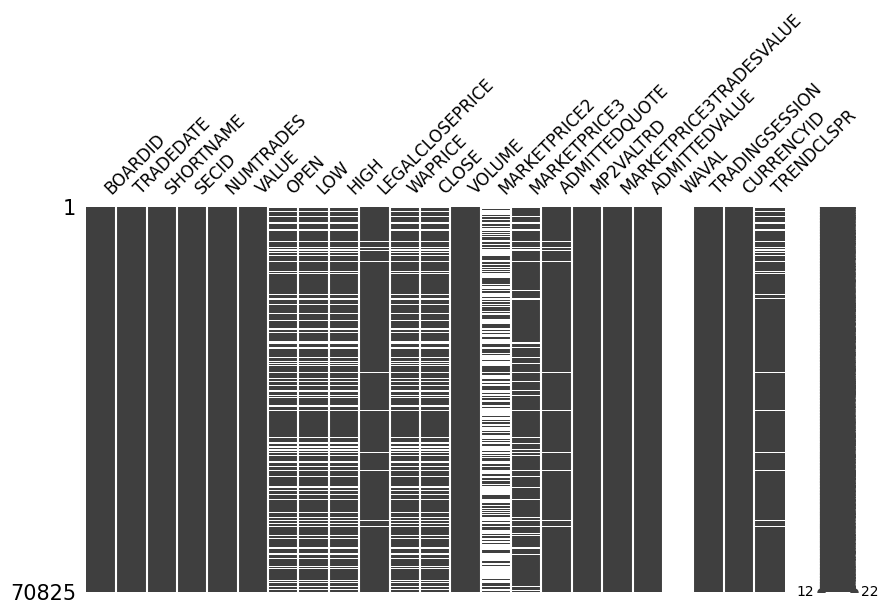

In [49]:
missingno.matrix(history_data, figsize=(10,5), fontsize=12);

In [52]:
history_data[history_data.OPEN.isna()][['TRADEDATE', 'SHORTNAME', 'SECID', 'NUMTRADES',	'VALUE', 'OPEN', 'LOW',	'HIGH',	'LEGALCLOSEPRICE', 'CLOSE', 'VOLUME']]

TRADEDATE   SHORTNAME  SECID  NUMTRADES  VALUE  OPEN  LOW  HIGH  \
2      2018-01-03     АСКО ао   ACKO          0    0.0   NaN  NaN   NaN   
7      2018-01-03  БестЭфБ ао   ALBK          0    0.0   NaN  NaN   NaN   
8      2018-01-03  АЛРОСА-Нюр   ALNU          0    0.0   NaN  NaN   NaN   
21     2018-01-03  БашИнСв ао   BISV          0    0.0   NaN  NaN   NaN   
28     2018-01-03   РН-ЗапСиб   CHGZ          0    0.0   NaN  NaN   NaN   
...           ...         ...    ...        ...    ...   ...  ...   ...   
70802  2018-12-29    ВолгЭнСб   VGSB          0    0.0   NaN  NaN   NaN   
70803  2018-12-29  ВолгЭнСб-п  VGSBP          0    0.0   NaN  NaN   NaN   
70804  2018-12-29    Варьеган   VJGZ          0    0.0   NaN  NaN   NaN   
70805  2018-12-29  Варьеган-п  VJGZP          0    0.0   NaN  NaN   NaN   
70821  2018-12-29     ТНСэнЯр   YRSB          0    0.0   NaN  NaN   NaN   

       LEGALCLOSEPRICE  CLOSE  VOLUME  
2                6.510    NaN       0  
7              107.400    NaN       0  
8           146000.000    NaN       0  
21               8.700    NaN       0  
28              35.000    NaN       0  
...                ...    ...     ...  
70802            0.780    NaN       0  
70803            0.605    NaN       0  
70804          425.000    NaN       0  
70805          284.000    NaN       0  
70821           73.000    NaN       0  

[14579 rows x 11 columns]

В таком случае у нас есть 2 варианта: убираем данные либо об акциях, которые не торговались хотя бы один день, либо об акциях, которые не торговались более некоторого количества дней.

In [128]:
num_trade_day = history_data.groupby(by="SECID", as_index=False).aggregate({"TRADEDATE": "count"}).TRADEDATE.unique()
print("Всего акций до обработки:", history_data.SECID.nunique())
print("Кол-во наблюдений за каждой акцией:", num_trade_day)

Всего акций до обработки: 287
Кол-во наблюдений за каждой акцией: [188 254  69 196  39 122  43 234 195  63 251 236 140  10  98 243]


Если акция не торгуется больше, чем 25 дней, то мы убираем такую акцию.
Кол-во акций, которое придется убрать: 148
Кол-во акций, которое остается: 168


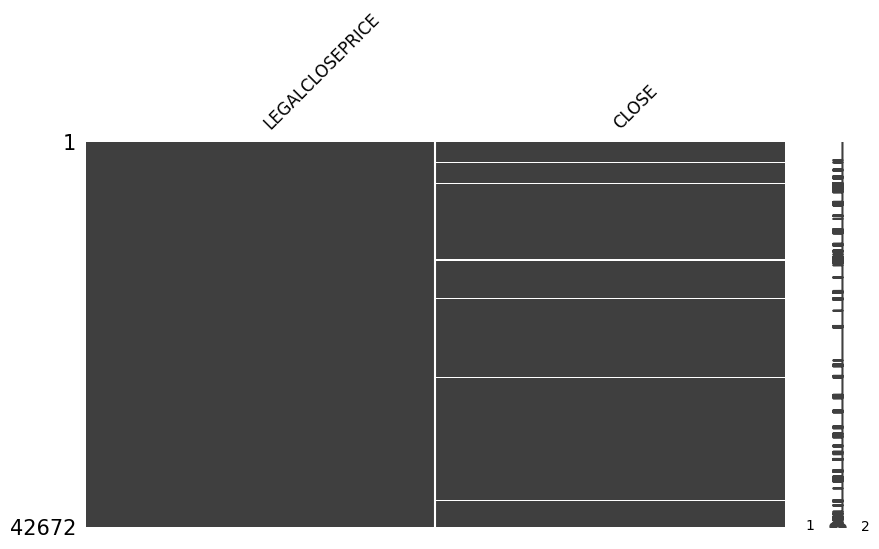

In [4]:
def get_cleaned_df(
    history_data : pd.DataFrame,
    NO_TRADES_DAY : int
    ) -> pd.DataFrame:
    
    stock_num_of_entries = history_data.groupby('SECID', as_index=False)['TRADEDATE'].count()
    stocks_to_drop_by_dates = (
                stock_num_of_entries
                # [stock_num_of_entries.TRADEDATE < (stock_num_of_entries.TRADEDATE.max() - NO_TRADES_DAY)]
                [stock_num_of_entries.TRADEDATE < stock_num_of_entries.TRADEDATE.max()]
                .SECID
                )

    no_trades_data = history_data[history_data.NUMTRADES == 0].groupby(by=["SECID"], as_index=False).count()
    stocks_to_drop_by_trades = no_trades_data[no_trades_data.NUMTRADES > NO_TRADES_DAY].SECID

    stocks_to_drop = pd.concat([stocks_to_drop_by_dates, stocks_to_drop_by_trades]).values
    data_after_drop = history_data[~history_data.SECID.isin(stocks_to_drop)]

    print(f"Если акция не торгуется больше, чем {NO_TRADES_DAY} дней, то мы убираем такую акцию.")
    print("Кол-во акций, которое придется убрать:", len(stocks_to_drop) + len(stocks_to_drop_by_dates))
    # print("Кол-во акций, которое остается:", history_data.SECID.nunique() - len(stocks_to_drop) - len(stocks_to_drop_by_dates))
    print("Кол-во акций, которое остается:", data_after_drop.SECID.nunique())
    return data_after_drop

history_data = get_cleaned_df(history_data, 25)

missingno.matrix(history_data.sort_values(by=["SECID", "TRADEDATE"])[["LEGALCLOSEPRICE", "CLOSE"]], figsize=(10,5), fontsize=12);

In [138]:
history_data.to_csv('data/history_data.csv', encoding='utf-16', index=False)

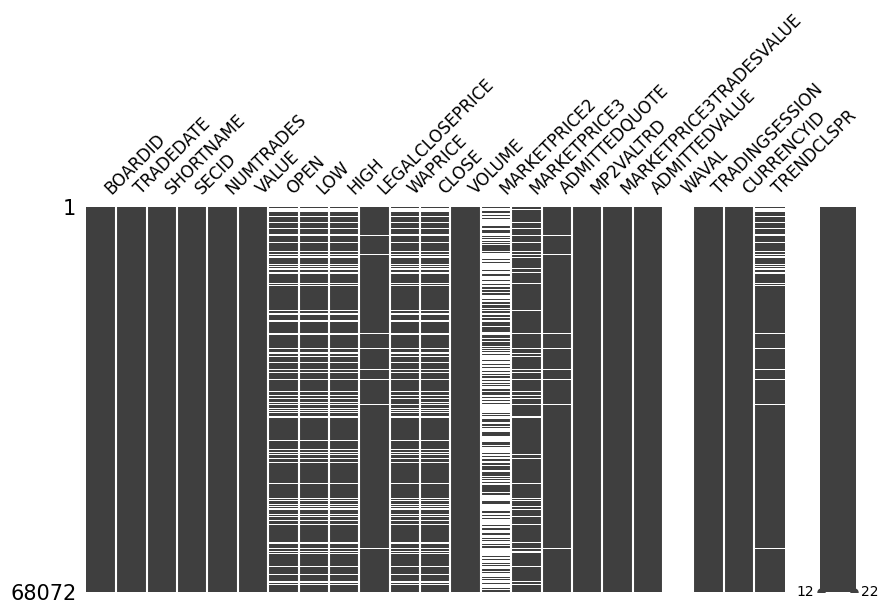

In [34]:
missingno.matrix(history_data, figsize=(10,5), fontsize=12);

In [5]:
COLUMNS_TO_DROP = [
    "BOARDID",
    "SHORTNAME",
    "VALUE",
    "OPEN",
    "LOW",
    "HIGH",
    "WAPRICE",
    "MARKETPRICE2",
    "MARKETPRICE3",
    "ADMITTEDQUOTE",
    "MP2VALTRD",
    "MARKETPRICE3TRADESVALUE",
    "ADMITTEDVALUE",
    "WAVAL",
    "TRADINGSESSION",
    "CURRENCYID",
]
history_data = history_data.drop(columns=COLUMNS_TO_DROP)
history_data.sample(5, random_state=SEED)

TRADEDATE SECID  NUMTRADES  LEGALCLOSEPRICE      CLOSE    VOLUME  \
50181  2018-09-17  KUZB         63           0.0096     0.0096   9980000   
17640  2018-04-04  MSNG        891           2.8880     2.8880  11570000   
14865  2018-03-21  PRTK         48         103.8000   103.8000     17400   
41431  2018-08-02  TRCN         13        4445.0000  4440.0000        47   
64525  2018-11-29  CHEP          5         111.6000   111.6000       500   

       TRENDCLSPR  
50181       -6.80  
17640       -1.16  
14865        0.87  
41431       -1.55  
64525        1.27

In [6]:
from functions import get_df_with_return

data_with_return = get_df_with_return(history_data, first_day_value=0.0)
data_with_return.sort_values(by=["SECID", "TRADEDATE"])

TRADEDATE SECID  NUMTRADES  LEGALCLOSEPRICE   CLOSE    VOLUME  \
3      2018-01-03  AFKS       5071           12.350  12.350  20687500   
286    2018-01-04  AFKS       4362           12.385  12.385  14880200   
569    2018-01-05  AFKS       3666           12.390  12.390  11072000   
852    2018-01-09  AFKS       9167           12.715  12.715  30905600   
1135   2018-01-10  AFKS       4446           12.700  12.700  11774300   
...           ...   ...        ...              ...     ...       ...   
69734  2018-12-25  ZVEZ         15            4.650   4.620     26000   
70008  2018-12-26  ZVEZ          6            4.700   4.700      6000   
70280  2018-12-27  ZVEZ          7            4.650   4.650     20000   
70552  2018-12-28  ZVEZ         21            4.660   4.660     60000   
70824  2018-12-29  ZVEZ         19            4.690   4.690     34000   

       TRENDCLSPR    RETURN  
3            2.15  0.000000  
286          0.28  0.002830  
569          0.04  0.000404  
852          2.62  0.025893  
1135        -0.12 -0.001180  
...           ...       ...  
69734       -0.65  0.000000  
70008        1.73  0.010695  
70280       -1.06 -0.010695  
70552        0.22  0.002148  
70824        0.64  0.006417  

[42672 rows x 8 columns]

In [7]:
def get_df_with_mean_std_return(df: pd.DataFrame,
    stocks_id: str="SECID",
    stock_return: str="RETURN",
    ) -> pd.DataFrame:
    
    tickers = df[stocks_id].unique()
    df["MEAN_RETURN"] = 0.0
    df["STD_RETURN"] = 0.0

    for ticker in tickers:
        ticker_window = (df.SECID == ticker)
        df.loc[ticker_window, "MEAN_RETURN"] = df.loc[ticker_window, stock_return].mean()
        df.loc[ticker_window, "STD_RETURN"] = df.loc[ticker_window, stock_return].std()
    
    return df

data_with_return = get_df_with_mean_std_return(data_with_return)

stock_characteristics = data_with_return[['SECID', 'RETURN', 'MEAN_RETURN', 'STD_RETURN']].groupby('SECID').first().reset_index().drop(columns=['RETURN'])
stock_characteristics

SECID  MEAN_RETURN  STD_RETURN
0    AFKS    -0.001710    0.016348
1    AFLT    -0.001290    0.019499
2    AGRO     0.001292    0.012210
3    AKRN     0.000713    0.008926
4    ALRS     0.001036    0.016165
..    ...          ...         ...
163  WTCM     0.000033    0.023961
164  YKEN    -0.000569    0.021877
165  YNDX    -0.000027    0.024079
166  ZILL    -0.000842    0.023495
167  ZVEZ     0.000163    0.041932

[168 rows x 3 columns]

Посмотрим сколько дней доходность 0.

In [258]:
data_with_return[data_with_return.RETURN == 0.0]\
    .groupby(by="SECID", as_index=False)\
    .aggregate({"RETURN":"count"})\
    .rename(columns={"RETURN": "DAYS OF ZERO RETURN"})\
    .sort_values(by="DAYS OF ZERO RETURN", ascending=False)

SECID  DAYS OF ZERO RETURN
97    OPIN                  111
7     AVAZ                   75
8    AVAZP                   72
112   RLMN                   71
147   TNSE                   70
..     ...                  ...
85    MTLR                    2
118   RSTI                    1
126  SBERP                    1
64    MAGN                    1
139   TATN                    1

[168 rows x 2 columns]

Так как таких дней не очень много, поэтому пока оставим эти данные.

In [156]:
fig = px.scatter(stock_characteristics, x="STD_RETURN", y="MEAN_RETURN",
                title="«Карта» активов",
                labels={
                     "STD_RETURN": "Стандартное отклонение",
                     "MEAN_RETURN": "Мат. ожидание"})
fig.show()

Средняя доходность большей части активов колеблется в пределах от -0.002 до 0.002, риск - от 0.01 до 0.025. Тем не менее, достаточно много активов обладают высоким риском при невысокой доходности (но есть исключения). Больше половины акций обладают отрицательной доходностью.

In [254]:
stock_characteristics[stock_characteristics.STD_RETURN > 0.04].sort_values(by='STD_RETURN', ascending=False)

SECID  MEAN_RETURN  STD_RETURN
130   SIBG    -0.002212    0.092239
83    MSST     0.003257    0.081203
112   RLMN    -0.001231    0.064417
138   TANL     0.000605    0.054761
123   RUGR    -0.000192    0.054252
32    FTRE    -0.004399    0.054232
43    IRKT     0.003519    0.053827
19   CLSBP    -0.002890    0.050778
22    DASB    -0.000442    0.050507
18    CLSB    -0.001593    0.049807
55   KZOSP    -0.000018    0.048521
25    DVEC     0.002326    0.042845
167   ZVEZ     0.000163    0.041932
28    ENPL    -0.002552    0.041539
113  RLMNP    -0.002379    0.040536

Посмотрим на некоторые компании с высоким риском и высокой доходностью:

IRKT - ПАО "Яковлев", производство гражданских самолетов\
MSST - ОАО "Мультсистема", коммунальные услуги\
DVEC - ПАО "Дальневосточная энергетическая компания", энергетическая сбытовая компания

Компании с высоким риском и низкой (отрицательной) доходностью:

SIBG - ПАО «Айс стим Рус», продукты сублимационной сушки и пищевых компонентов\
RLMN - ПАО «Группа Компаний „Роллман“», химикаты\
RUGR - "РУСГРЭЙН ХОЛДИНГ", еда и табачные изделия

# Задание 4
Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E).
Дайте характеристику индексу рынка.

Индекс МосБиржи - ценовой взвешенный по рыночной капитализации композитный индекс российского фондового рынка, включающие наиболее ликвидные акции крупнейших и динамично развивающихся российских эмитентов, виды экономической деятельности которых относятся к основным секторам экономики.

In [51]:
history_index_data = history_index_data[['SECID', 'TRADEDATE', 'NAME',	'CLOSE', 'OPEN', 'HIGH', 'LOW',	'VALUE']]
history_index_data

SECID   TRADEDATE             NAME    CLOSE     OPEN     HIGH      LOW  \
0    IMOEX  2018-01-03  Индекс МосБиржи  2152.97  2111.24  2152.97  2111.24   
1    IMOEX  2018-01-04  Индекс МосБиржи  2197.60  2153.87  2197.60  2153.87   
2    IMOEX  2018-01-05  Индекс МосБиржи  2207.41  2196.69  2207.41  2188.35   
3    IMOEX  2018-01-09  Индекс МосБиржи  2225.39  2211.40  2242.87  2211.40   
4    IMOEX  2018-01-10  Индекс МосБиржи  2232.27  2227.33  2233.63  2213.77   
..     ...         ...              ...      ...      ...      ...      ...   
249  IMOEX  2018-12-25  Индекс МосБиржи  2290.86  2318.43  2318.43  2258.27   
250  IMOEX  2018-12-26  Индекс МосБиржи  2308.85  2291.98  2315.98  2291.98   
251  IMOEX  2018-12-27  Индекс МосБиржи  2327.81  2316.66  2340.63  2316.66   
252  IMOEX  2018-12-28  Индекс МосБиржи  2358.50  2329.96  2369.24  2329.96   
253  IMOEX  2018-12-29  Индекс МосБиржи  2369.33  2359.38  2370.00  2357.10   

            VALUE  
0    2.107610e+10  
1    3.653125e+10  
2    2.598557e+10  
3    4.438950e+10  
4    4.008192e+10  
..            ...  
249  1.856123e+10  
250  1.494648e+10  
251  2.811124e+10  
252  2.367390e+10  
253  5.558291e+09  

[254 rows x 8 columns]

In [249]:
index_data_with_return = get_df_with_return(history_index_data, price_name='CLOSE', first_day_value=0.0)
index_data_characteristics = get_df_with_mean_std_return(index_data_with_return[['SECID', 'RETURN']].copy()).groupby('SECID').first().reset_index().drop(columns=['RETURN'])
index_data_characteristics

SECID  MEAN_RETURN  STD_RETURN
0  IMOEX     0.000377    0.010814

In [253]:
px.line(index_data_with_return, x='TRADEDATE', y='RETURN', title='Динамика доходностей индекса Московоской биржи')

In [252]:
px.line(index_data_with_return, x='TRADEDATE', y='CLOSE', title='Динамика индекса Московской биржи')

В целом индекс показывает положительную динамику. В апреле наблюдаем резкое падение мндекса - повлияло ожесточение санкций США. Осенью индекс стал расти из-за повышения цен на нефть, соответсвенно стали расти акций "Газпрома", "Лукойла", "Роснефти" и других связанных с нефтью компаний. 

In [92]:
fig = px.scatter(stock_characteristics, x="STD_RETURN", y="MEAN_RETURN",
                title="«Карта» активов",
                labels={
                     "STD_RETURN": "Стандартное отклонение",
                     "MEAN_RETURN": "Мат. ожидание"})

fig.add_scatter(x=index_data_characteristics['STD_RETURN'],
                y=index_data_characteristics['MEAN_RETURN'],
                marker=dict(color='red',size=10),
               name='IMOEX')

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

# Задание 7
Выберите несколько интересных (значимых) активов рынка из разных
производственных секторов. В предположении, что наблюдаемые доходности
(объемы продаж) являются повторной выборкой из некоторого распределения
исследовать (выборочно) распределения доходностей и объемов продаж выбранных
активов. Сделать выводы.

Выберем компании, которые входят в индекс голубых фишек МосБиржи на 2018 (индекс рассчитывается на основании цен сделок с акциями 15-ти наиболее ликвидных акций российского фондового рынка или так называемых "голубых фишек"):\
\
GAZP - ПАО "Газпром", Энергетические и минеральные ресурсы\
SBER - ПАО "СберБанк России", финансы, банки\
GMKN - ПАО ГМК "Норильский Никель", Несырьевые полезные ископаемые\
MGNT - ПАО "Магнит", розничная торговля, продуктовая розница\
IRAO - ПАО Интер РАО ЕЭС, коммунальные услуги, электроэнергетика\
YNDX - Yandex NV, технологии, интернет-сервисы и ПО\
\
Сначала построим гистограммы распределения доходностей и объёмов продаж:

In [8]:
stocks_to_analyze = ['GAZP', 'SBER', 'GMKN', 'MGNT', 'IRAO', 'YNDX']

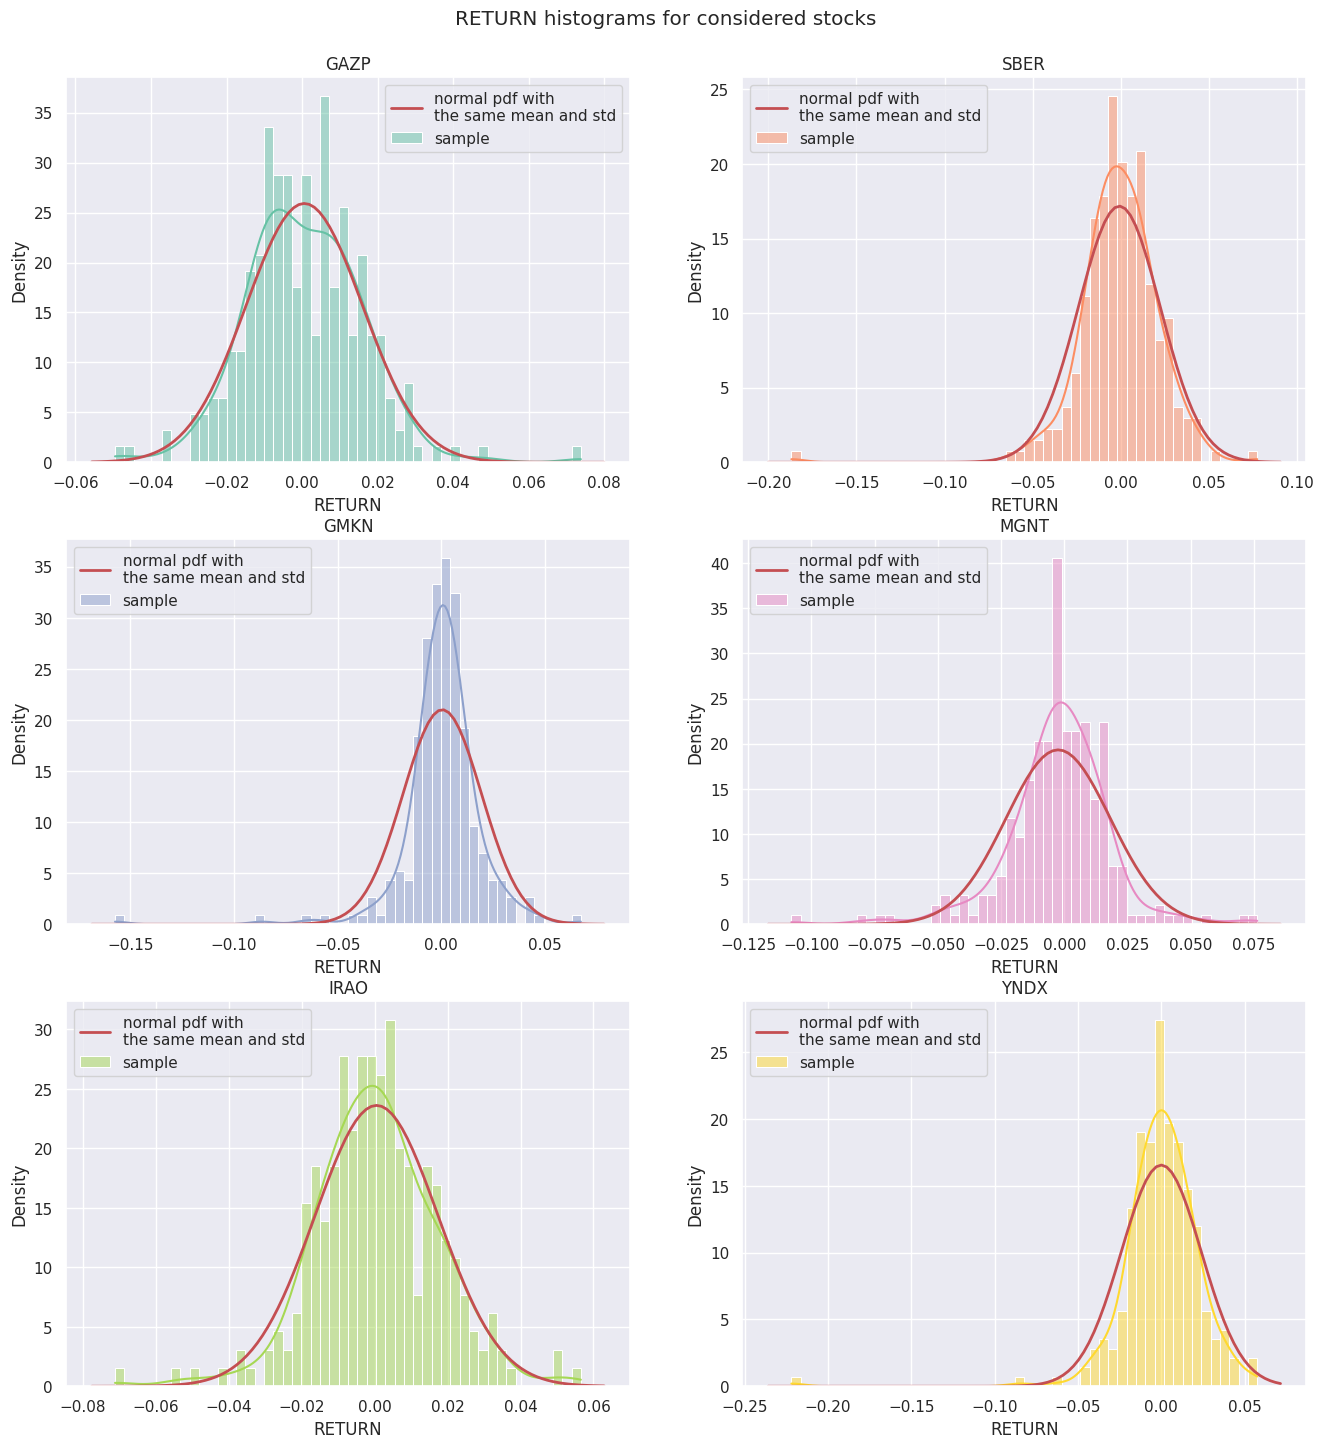

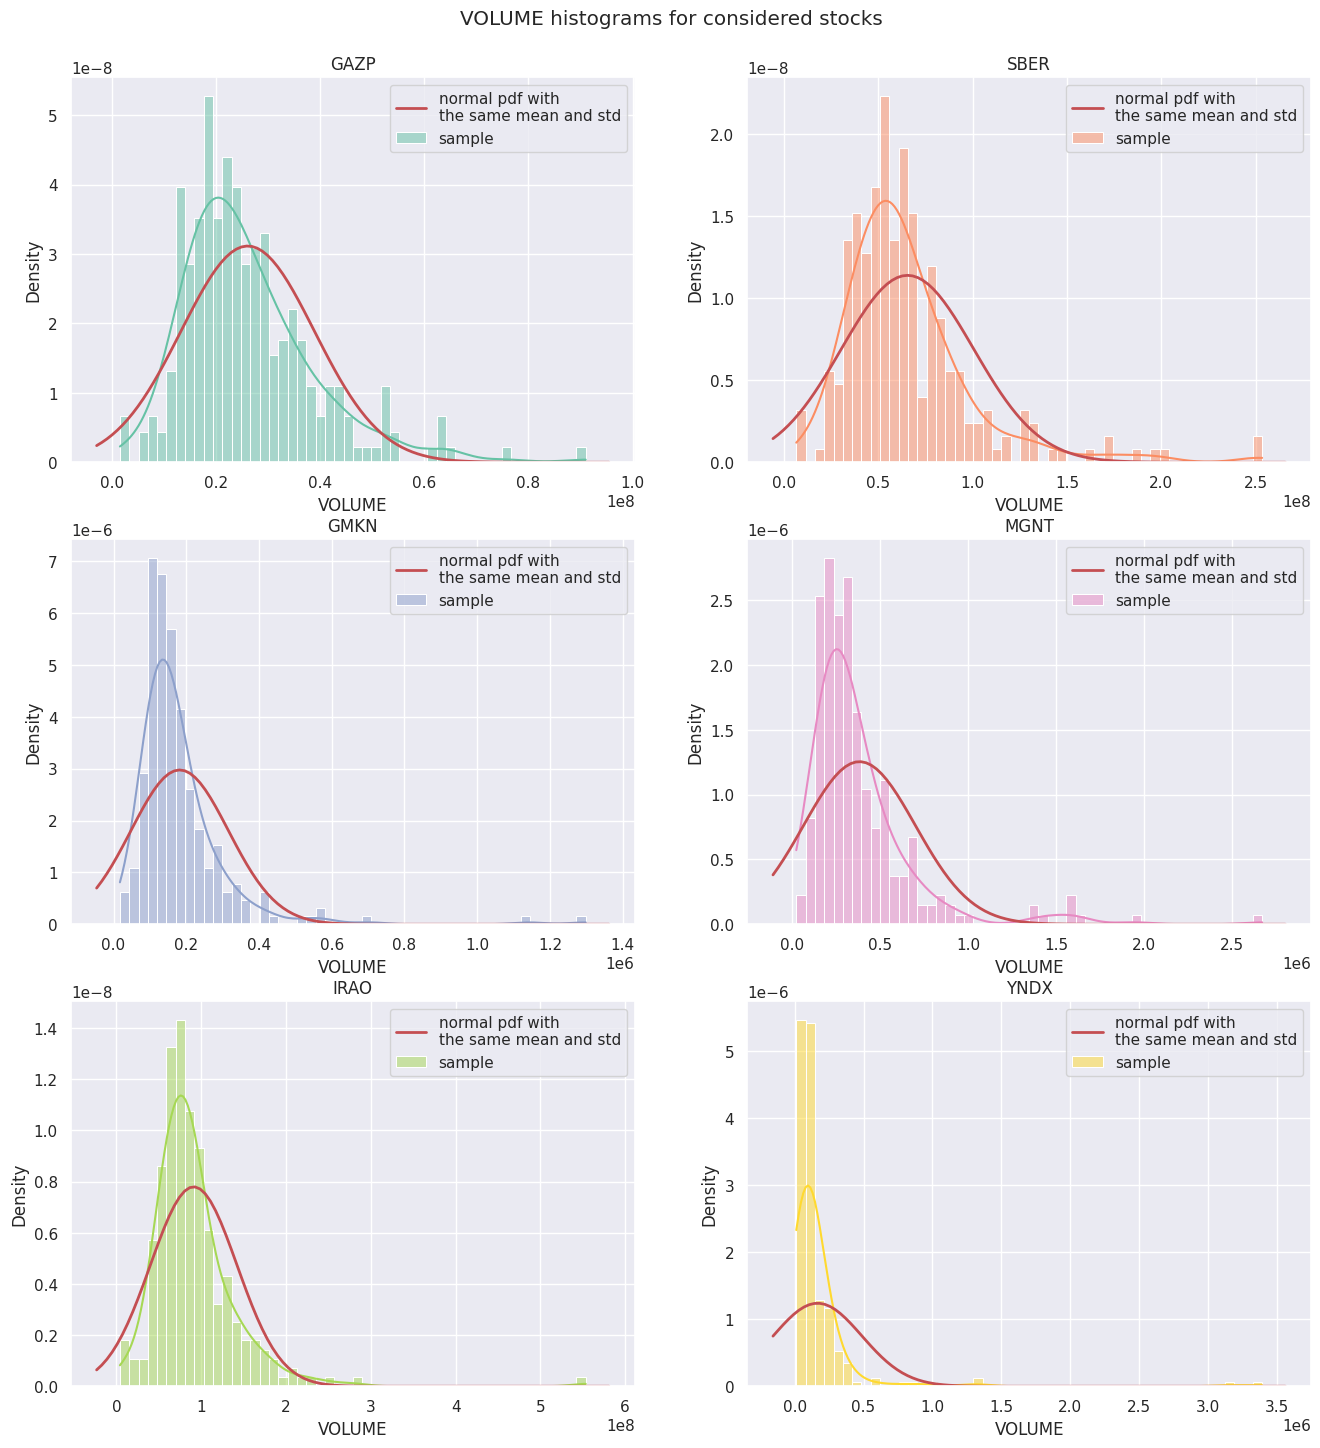

In [73]:
def plot_hists_for_distribution_test(df, column, stock_list):
    sns.set(style="darkgrid")
    colors = sns.color_palette('Set2')
    nrows, ncols = 3, 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 17))

    for i in range(nrows):
        for j in range(ncols):
            
            data_to_plot = df[df.SECID == stock_list[i*ncols+j]]
            
            g = sns.histplot(x=data_to_plot[column], kde=True, bins=50, color=colors[i*ncols+j], ax=ax[i, j], stat='density', label='sample')
            
            x0, x1 = g.get_xlim() 
            x_pdf = np.linspace(x0, x1, 100)
            y_pdf = stats.norm.pdf(x_pdf, loc=data_to_plot[column].mean(),
                                scale=data_to_plot[column].std())

            g.plot(x_pdf, y_pdf, 'r', lw=2, label=f'normal pdf with\nthe same mean and std')                                                   
            g.legend()
            g.set(title=stock_list[i*ncols+j])
            
    fig.suptitle(f'{column} histograms for considered stocks', y=0.92)
    plt.show()
    
plot_hists_for_distribution_test(data_with_return, 'RETURN', stocks_to_analyze)
plot_hists_for_distribution_test(data_with_return, 'VOLUME', stocks_to_analyze)

На графиках красным цветом построена функция плотности нормального распределения с средним и стандартным отклонением, вычисленными по выборке логарифмической доходности или объёма продаж для каждой акции. Гистограммы объёмов продаж однозначно не похожи на нормальное распределение,  а по гистограммам лог.доходности не можем утверждать точно (распределение колоколообразно, но относительно далеко от настоящего нормального с теми же параметрами).

Попробуем другой графический метод проверки на нормальность: Q-Q plot. 

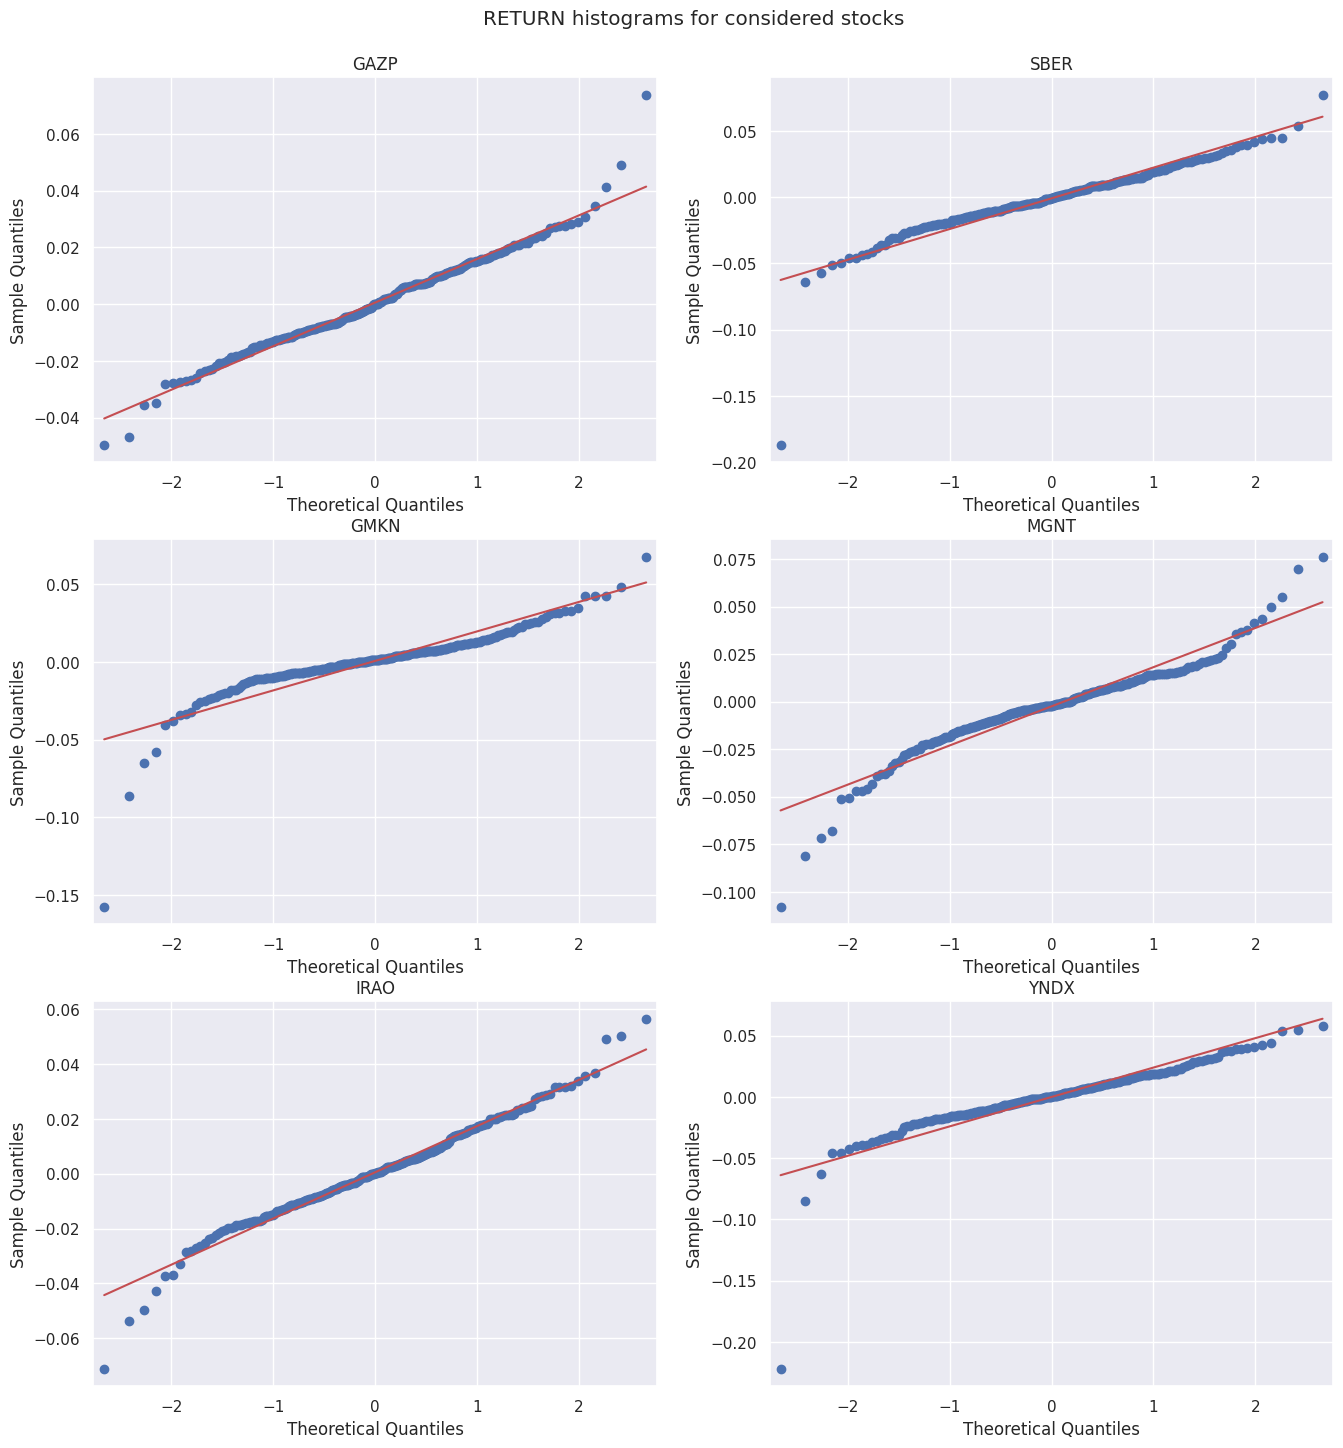

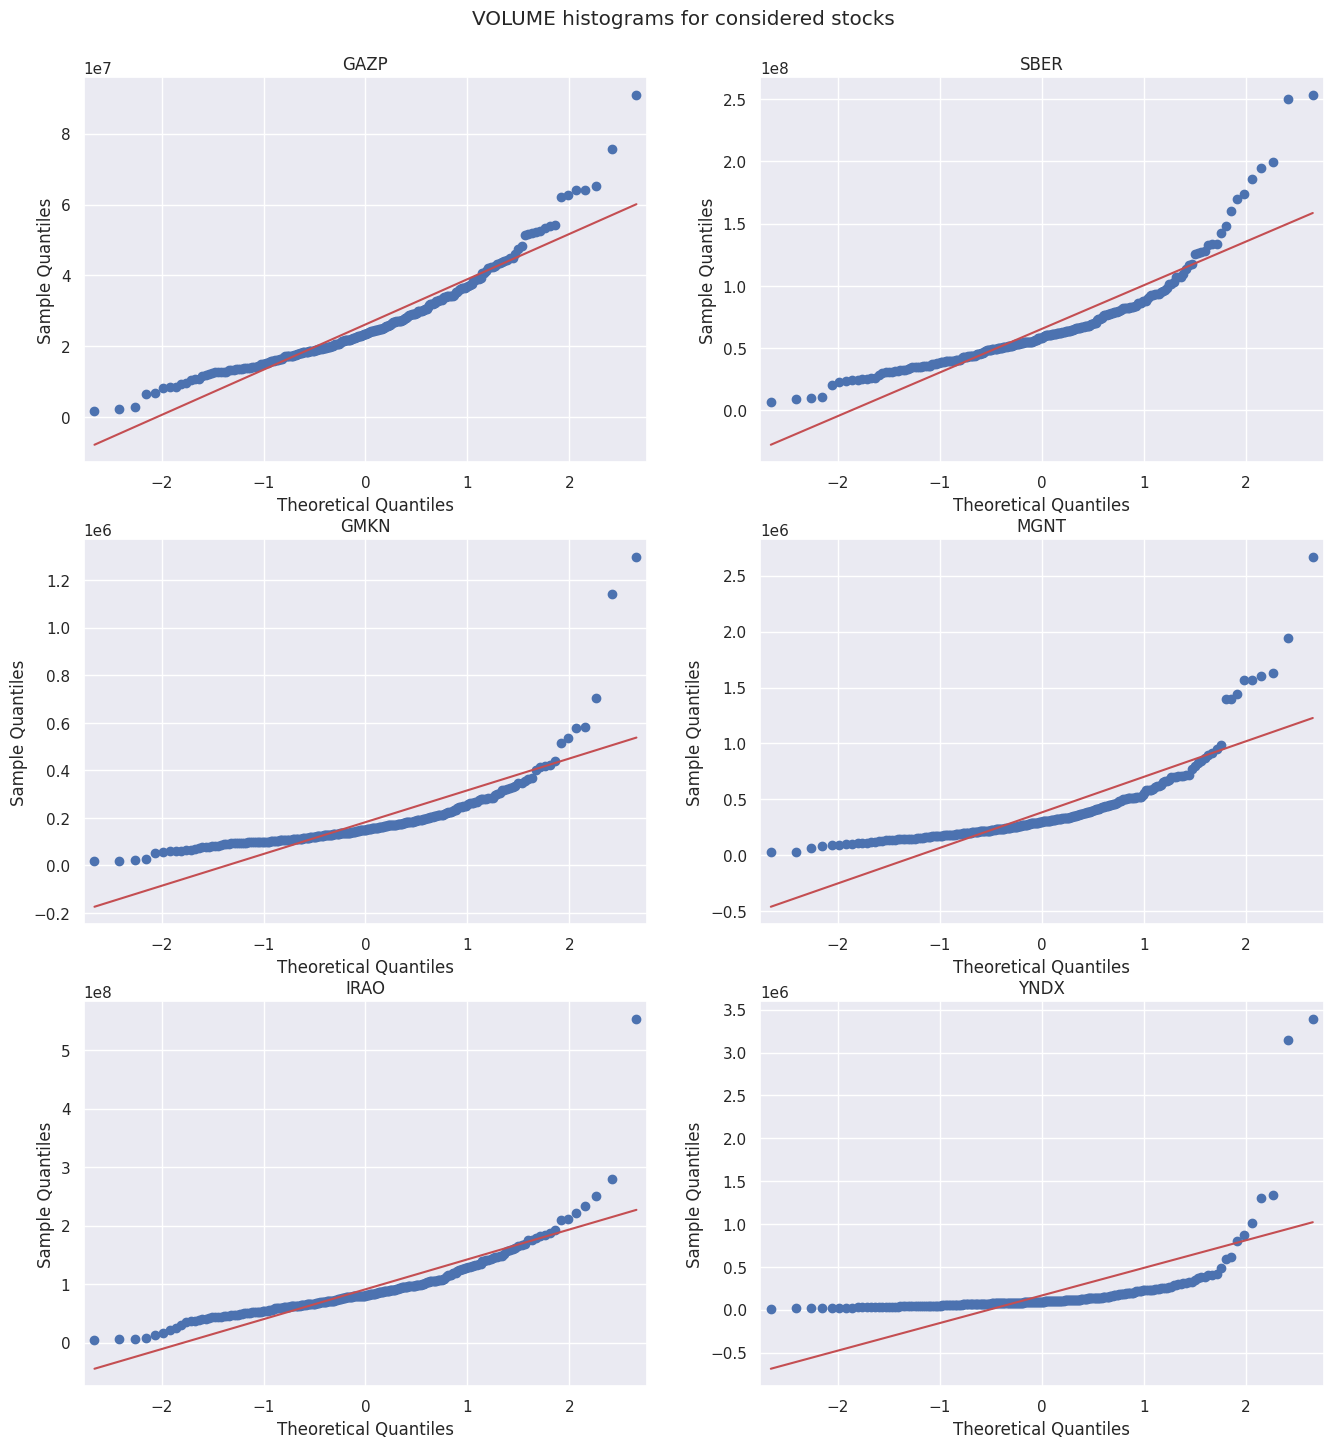

In [117]:
import statsmodels.api as sm

def plot_qq_for_distribution_test(df, column, stock_list):
    sns.set(style="darkgrid")
    nrows, ncols = 3, 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 17))

    for i in range(nrows):
        for j in range(ncols):
            g = sm.qqplot(df[df.SECID == stock_list[i*ncols+j]][column], line='s', ax=ax[i, j])
            ax[i, j].set(title=stock_list[i*ncols+j])
    
    fig.suptitle(f'{column} histograms for considered stocks', y=0.92)
    plt.show()
    
plot_qq_for_distribution_test(data_with_return, 'RETURN', stocks_to_analyze)
plot_qq_for_distribution_test(data_with_return, 'VOLUME', stocks_to_analyze)

Q-Q plots для акций GAZP, SBER, IRAO показывают, что распределение доходностей этих акций близко к нормальному распределению (мешают "хвосты"). Квантиль-квантиль графики для других акций показывают, что распределение далеко от нормального (не соответствует линии главного тренда). Насчет распределений объемов продаж можем утверждать, что они имеют не нормальное распределение для всех рассматриваемых акций. 

Проверим нормальность с помощью статистических тестов:

In [147]:
from scipy.stats import normaltest, shapiro, kstest
from typing import Any
from statsmodels.stats.diagnostic import anderson_statistic, normal_ad

def normal_distribution_test(
    data : Any, 
    data_name : str, 
    alpha :float = 0.05) -> None:
    
    tests = {"D'Agostino and Pearson test" : normaltest,
         'Shapiro-Wilk test' : shapiro,
         "Kolmogorov-Smirnov test" : kstest,
         "Anderson-Darling test" : normal_ad}
    
    print(f"Проверяем гипотезу о нормальности {data_name}:\n")
    
    for test_name, test_callable in tests.items():
        if test_name == "Kolmogorov-Smirnov test":
            statistic, pvalue = test_callable(data, "norm", args=(data.mean(), data.std()))
            
        else:
            statistic, pvalue = test_callable(data)
            
        if pvalue > alpha:
            print(f"\t{test_name}: pvalue = {pvalue:.5f}\n\tГипотеза о нормальности не отвергается\n")
        else:
            print(f"\t{test_name}: pvalue = {pvalue:.5f}\n\tГипотеза о нормальности отвергается\n")
            
def get_tests_results(
    stock_list : Any, 
    df : pd.DataFrame, 
    alpha : float = 0.05) -> None:
    
    for stock in stock_list:
        print(f"{stock}")
        normal_distribution_test(df[df.SECID == stock].RETURN.values, "log.return")
        normal_distribution_test(df[df.SECID == stock].VOLUME.values, "volume")

In [203]:
get_tests_results(stocks_to_analyze, data_with_return)

GAZP
Проверяем гипотезу о нормальности log.return:

	D'Agostino and Pearson test: pvalue = 0.00005
	Гипотеза о нормальности отвергается

	Shapiro-Wilk test: pvalue = 0.00088
	Гипотеза о нормальности отвергается

	Kolmogorov-Smirnov test: pvalue = 0.81956
	Гипотеза о нормальности не отвергается

	Anderson-Darling test: pvalue = 0.09456
	Гипотеза о нормальности не отвергается

Проверяем гипотезу о нормальности volume:

	D'Agostino and Pearson test: pvalue = 0.00000
	Гипотеза о нормальности отвергается

	Shapiro-Wilk test: pvalue = 0.00000
	Гипотеза о нормальности отвергается

	Kolmogorov-Smirnov test: pvalue = 0.00566
	Гипотеза о нормальности отвергается

	Anderson-Darling test: pvalue = 0.00000
	Гипотеза о нормальности отвергается

SBER
Проверяем гипотезу о нормальности log.return:

	D'Agostino and Pearson test: pvalue = 0.00000
	Гипотеза о нормальности отвергается

	Shapiro-Wilk test: pvalue = 0.00000
	Гипотеза о нормальности отвергается

	Kolmogorov-Smirnov test: pvalue = 0.10524
	Гип

В результате получается, что тесты Колмогорова-Смиронова и Андерсона-Дарлинга не отвергают гипотезу о нормальности распределения доходностей "Газпрома" GAZP, 
тесты Колмогорова-Смиронова не отвергают гипотезу о нормальности распределения доходностей "Сбера" SBER и "Интер РАО ЕЭС" IRAO, в остальных случаях гипотезы о нормальности отвергнуты.

In [198]:
stocks_to_plot = ['GAZP', 'SBER', 'IRAO']
fig = px.line(data_with_return[data_with_return.SECID.isin(stocks_to_plot)], x='TRADEDATE', y='RETURN', color='SECID',
              color_discrete_sequence=px.colors.qualitative.Set1, width=1500, height=800)
fig.show()

In [200]:
stocks_to_analyze

['GAZP', 'SBER', 'GMKN', 'MGNT', 'IRAO', 'YNDX']

In [202]:

fig = px.line(data_with_return[data_with_return.SECID.isin(stocks_to_analyze)], x='TRADEDATE', y='RETURN', color='SECID',
              color_discrete_sequence=px.colors.qualitative.Set1, width=1500, height=800)
fig.show()